Automatically created module for IPython interactive environment


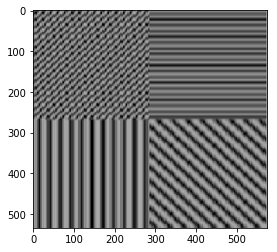

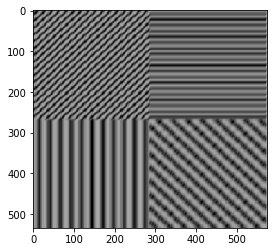

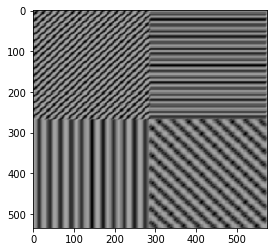

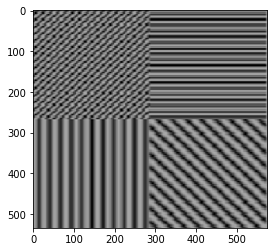

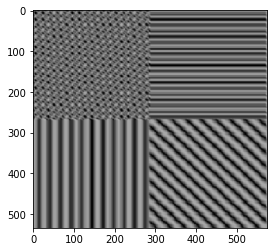

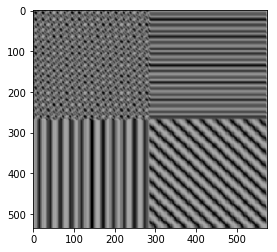

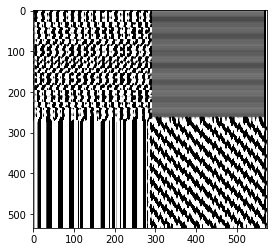

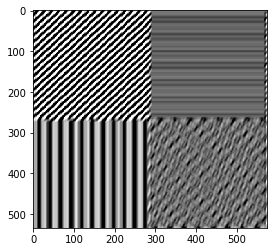

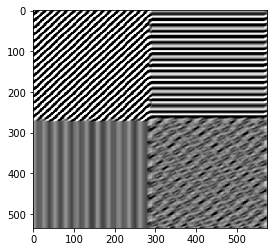

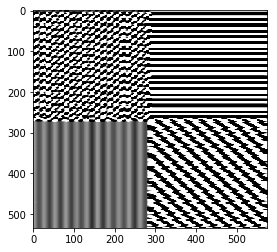

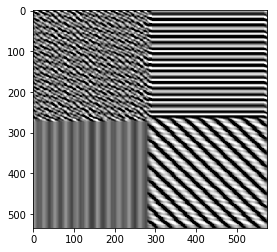

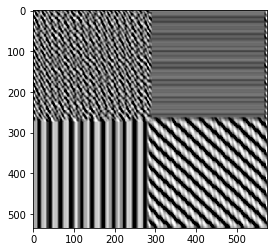

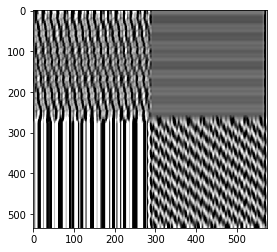

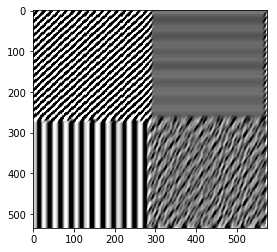

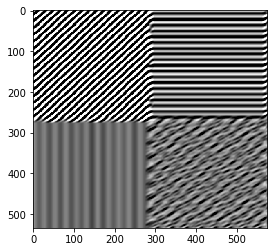

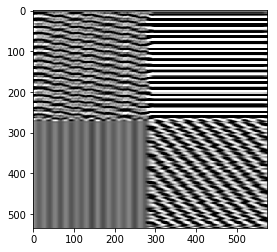

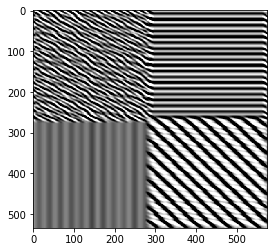

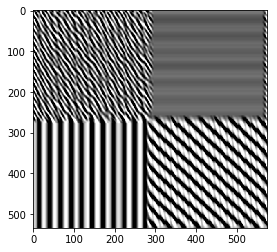

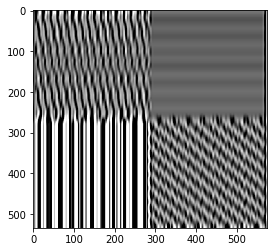

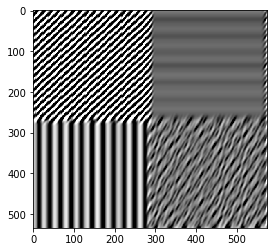

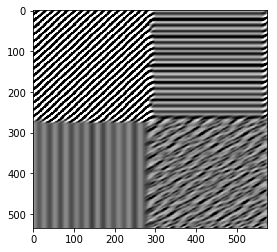

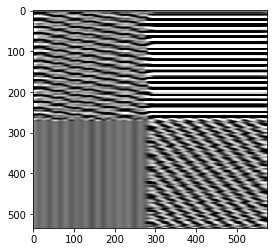

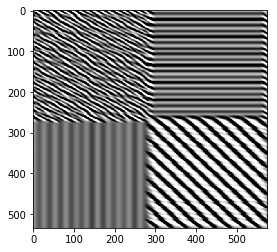

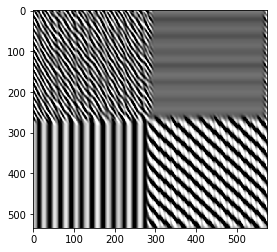

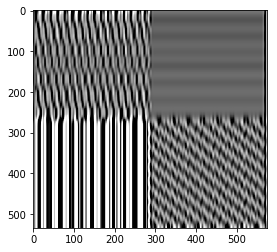

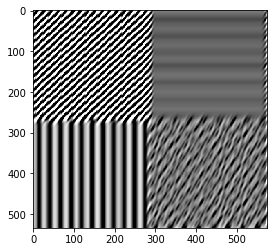

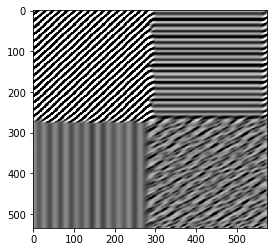

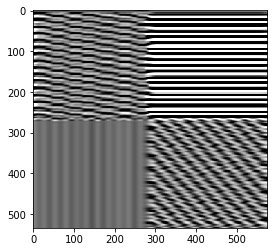

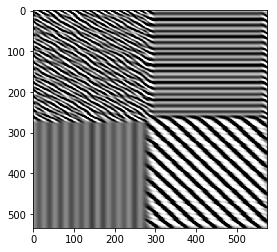

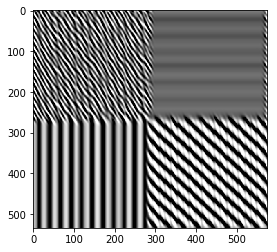

Done


In [2]:
# import numpy as np
# import cv2 as cv
# import matplotlib.pyplot as plt

# from multiprocessing.pool import ThreadPool


# def build_filters():
#     filters = []
#     for ksize in [7,15,23,32,64]:
#         for theta in np.arange(0, np.pi, np.pi / 6):
#             kern = cv.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv.CV_32F)
#             kern /= 1.5*kern.sum()
#             filters.append(kern)
#     return filters

# def process(img, filters):
#     accum = np.zeros_like(img)
#     for kern in filters:
#         fimg = cv.filter2D(img, cv.CV_8UC3, kern)
#         plt.imshow(fimg)
#         plt.pause(0.3)
#         np.maximum(accum, fimg, accum)
#     return accum

# def process_threaded(img, filters, threadn = 8):
#     accum = np.zeros_like(img)
#     def f(kern):
#         return cv.filter2D(img, cv.CV_8UC3, kern)
#     pool = ThreadPool(processes=threadn)
#     for fimg in pool.imap_unordered(f, filters):
#         np.maximum(accum, fimg, accum)
#     return accum

# def main():
#     import sys
# #     from common import Timer

#     img_fn = 'pattern.PNG'

#     img = cv.imread(img_fn)
#     if img is None:
#         print('Failed to load image file:', img_fn)
#         sys.exit(1)

#     filters = build_filters()

# #     with Timer('running single-threaded'):
#     res1 = process(img, filters)
# #     with Timer('running multi-threaded'):
# #         res2 = process_threaded(img, filters)

# #     print('res1 == res2: ', (res1 == res2).all())
# #     cv.imshow('img', img)
#     cv.imshow('result', res1)
#     cv.waitKey(0)
#     print('Done')


# if __name__ == '__main__':
#     print(__doc__)
#     main()
#     cv.destroyAllWindows()

In [7]:
import numpy as np
FF = np.zeros((1,1),dtype=np.double)

In [8]:
import os
import cv2
from scipy.misc import imread
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage.filters as filters
from skimage import measure
import matplotlib.pyplot as plt
import copy

from skimage.filters import gabor_kernel
from scipy import ndimage as nd

kernels = []
for ksize in [15,21,31,63]:
    for theta in np.arange(0, np.pi, np.pi / 6):
        kern = cv2.getGaborKernel((ksize, ksize), 4., theta, 12.0, 0.5, 0, ktype=cv2.CV_32F) #13 was 10(4th parameter)
        # increase to consider narrow regions
        kern /= 1.5*kern.sum()
        kernels.append(kern)
print(len(kernels))

def process(img, filters):
    accum = []
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
#         np.maximum(accum, fimg, accum)
        accum.append(fimg)
    return accum


class drlse(object):

    def __init__(self, F, lamda, mu, alpha, epsilon, dt, iterations, potential_function):
        self.F = F
        self.lamda = lamda
        self.alpha = alpha
        self.epsilon = epsilon
        self.dt = dt
        self.mu = mu
        self.iter = iterations
        self.potential_function = potential_function

    def drlse_edge(self,phi):
        [vy, vx] = np.gradient(self.F)
        for k in range(self.iter):
            phi = self.applyNeumann(phi)
            [phi_y, phi_x] = np.gradient(phi)
            s = np.sqrt(np.square(phi_x) + np.square(phi_y))
            smallNumber = 1e-10
            Nx = phi_x / (s + smallNumber)
            Ny = phi_y / (s + smallNumber)
            curvature = self.div(Nx, Ny)
            if self.potential_function == 'single-well':
                distRegTerm = filters.laplace(phi, mode='wrap') - curvature
            elif self.potential_function == 'double-well':
                distRegTerm = self.distReg_p2(phi)
            else:
                print('Error: Wrong choice of potential function. Please input the string "single-well" or "double-well" in the drlse_edge function.')
            diracPhi = self.Dirac(phi)
            areaTerm = diracPhi * self.F
            edgeTerm = diracPhi * (vx * Nx + vy * Ny) + diracPhi * self.F * curvature
            phi = phi + self.dt * (self.mu * distRegTerm + self.lamda * edgeTerm + self.alpha * areaTerm)
        return phi

    def distReg_p2(self,phi):
        [phi_y, phi_x] = np.gradient(phi)
        s = np.sqrt(np.square(phi_x) + np.square(phi_y))
        a = (s >= 0) & (s <= 1)
        b = (s > 1)
        ps = a * np.sin(2 * np.pi * s) / (2 * np.pi) + b * (s - 1)
        dps = ((ps != 0) * ps + (ps == 0)) / ((s != 0) * s + (s == 0))
        return self.div(dps * phi_x - phi_x, dps * phi_y - phi_y) + filters.laplace(phi, mode='wrap')

    def div(self,nx, ny):
        [junk, nxx] = np.gradient(nx)
        [nyy, junk] = np.gradient(ny)
        return nxx + nyy

    def Dirac(self,x):
        f = (1 / 2 / self.epsilon) * (1 + np.cos(np.pi * x / self.epsilon))
        b = (x <= self.epsilon) & (x >= -self.epsilon)
        return f * b

    def applyNeumann(self,f):
        [ny, nx] = f.shape
        g = f.copy()
        g[0, 0] = g[2, 2]
        g[0, nx-1] = g[2, nx-3]
        g[ny-1, 0] = g[ny-3, 2]
        g[ny-1, nx-1] = g[ny-3, nx-3]

        g[0, 1:-1] = g[2, 1:-1]
        g[ny-1, 1:-1] = g[ny-3, 1:-1]

        g[1:-1, 0] = g[1:-1, 2]
        g[1:-1, nx-1] = g[1:-1, nx-3]
        return g



class levelSet(object):

    def __init__(self, drlse_iter, gradient_iter, lamda, alpha, epsilon, sigma, dt=1, potential_function="double-well"):
        self.lamda = lamda
        self.alpha = alpha
        self.epsilon = epsilon
        self.sigma = sigma
        self.dt = dt
        self.mu = 0.2/self.dt
        self.drlse_iter = drlse_iter
        self.gradient_iter = gradient_iter
        self.potential_function = potential_function

    def initializePhiAtScribble(self,image,x,y):
        c0 = 3
        phi = c0 * np.ones(image.shape)
        w = 8
        phi[x-w:x+w, y-w:y+w] = -c0
        return phi

    def visualization(self,image,phi):
        fig2 = plt.figure(2)
        fig2.clf()
        contours = measure.find_contours(phi, 0)
        ax2 = fig2.add_subplot(111)
        ax2.imshow(image, interpolation='nearest', cmap=plt.cm.gray)
        for n, contour in enumerate(contours):
            ax2.plot(contour[:, 1], contour[:, 0], linewidth=2)

    def calculateF_edge(self,image):
#         [Iy, Ix] = np.gradient(image)
        img_smooth = filters.gaussian_filter(image, self.sigma)
        [Iy, Ix] = np.gradient(img_smooth)
        F = np.square(Ix) + np.square(Iy)
#         print((1/(1+F)).shape)
        return 1 / (1+F)
    
    def compute_feats(self, filtered):
        feats = np.zeros((len(filtered), 2), dtype=np.double)
        for k, fltr in enumerate(filtered):
            feats[k, 0] = fltr.mean()
            feats[k, 1] = fltr.var()
        return feats

    def calculateF_pattern(self,image,x,y):
        w = 8
        filtered = process(image, kernels)
        window_scribble = [f[x-w:x+w, y-w:y+w] for f in filtered]
        scribble_feats = self.compute_feats(window_scribble)
        
        top, bottom, left, right = w, w-1, w, w-1
        WHITE = [255, 255, 255]
        padded = [cv2.copyMakeBorder(f, top , bottom, left, right, cv2.BORDER_REPLICATE, value=WHITE) \
                  for f in filtered]
    
        global FF
        if FF.shape[0] == 1:
            F = np.zeros(image.shape, dtype=np.double)
            step = 1
            for i in range(w, padded[0].shape[0]-w, step):
                for j in range(w, padded[0].shape[1]-w, step):

                    feats = self.compute_feats([f[i-w:i+w, j-w:j+w] for f in padded])
    #                 print(i,j)
                    F[i-w:i-w+step, j-w:j-w+step] = np.sum((feats - scribble_feats)**2)
#                     F[i-w:i-w+step, j-w:j-w+step] = np.sqrt(F[i-w:i-w+step, j-w:j-w+step])
            FF = F
        else:
            F = copy.deepcopy(FF)
        
#         F = (F - np.mean(F)) / np.std(F)
#         print(F)
#         F[F<17000] = 1
#         F[F>=17000] = 1000000
#         print(np.unique(F,return_counts=True))
#         print("")
#         X = 1./(1+F)
#         X = (X - np.mean(X)) / np.std(X)
#         print(X)
        plt.imshow(F)
        plt.pause(0.3)
        plt.imshow(1 / (1+F))
        plt.pause(0.3)
        return 1 / (1+F)

    def gradientDescent(self,image,x,y):
        self.phi = self.initializePhiAtScribble(image,x,y)
        self.FI = self.calculateF_edge(image)
        F = self.calculateF_pattern(image,x,y)
        lse = drlse(F, self.lamda, self.mu, self.alpha, self.epsilon, self.dt, self.drlse_iter, self.potential_function)
        for n in range(self.gradient_iter):
            self.phi = lse.drlse_edge(self.phi)
#             [phi_y, phi_x] = np.gradient(phi)
#             dphi = np.sqrt(np.square(phi_x) + np.square(phi_y))
#             phi = phi + self.dt * F * dphi
            if n % 10 == 0:
                self.visualization(image,self.phi)
                plt.pause(0.3)
        plt.pause(0.5)

24


(156, 324)


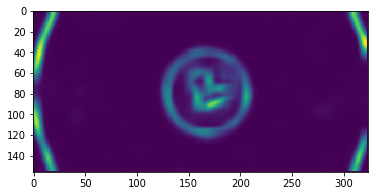

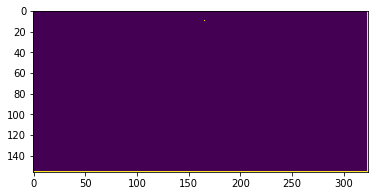

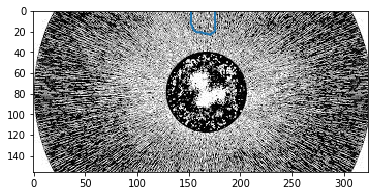

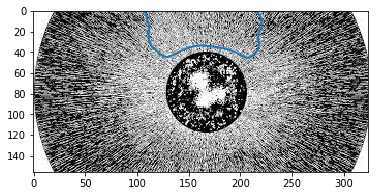

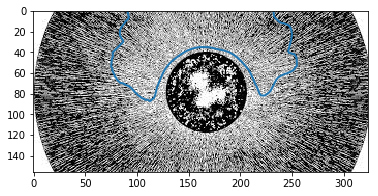

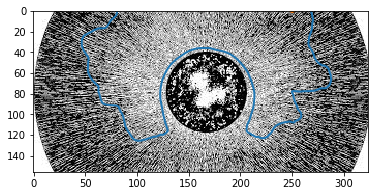

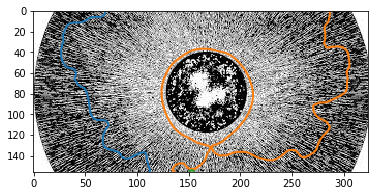

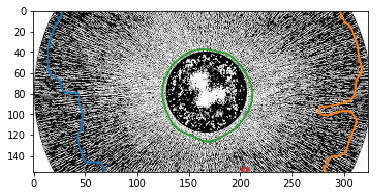

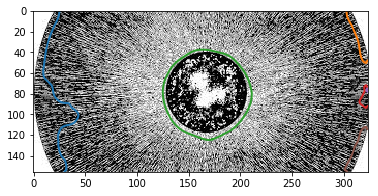

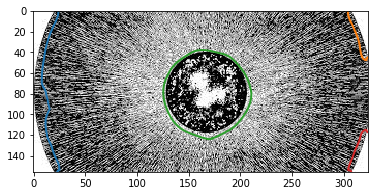

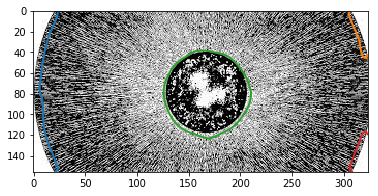

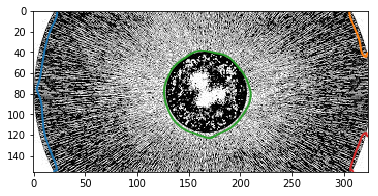

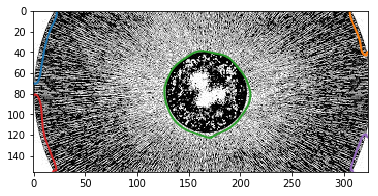

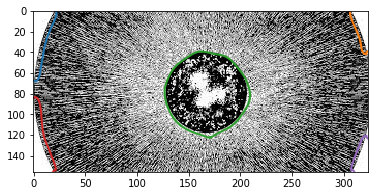

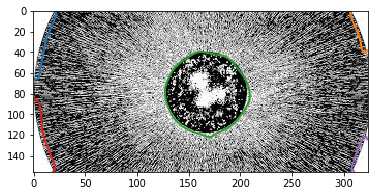

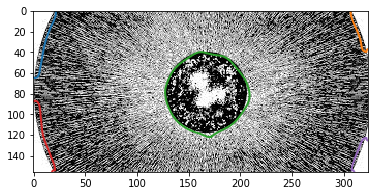

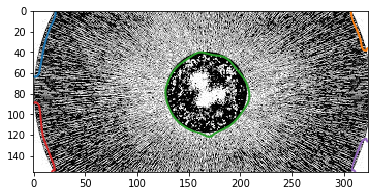

In [60]:
image = cv2.imread('pattern2.jpeg', cv2.IMREAD_GRAYSCALE)
# image = np.array(image,dtype='float32')
# image = (image - image.mean()) / image.std()
# image = cv2.resize(image,(250,250))
print(image.shape)
LS = levelSet(10,150,2,-5000000,2,1)#(10,3000,2,-9,2,0.8)
LS.gradientDescent(image,10,165)

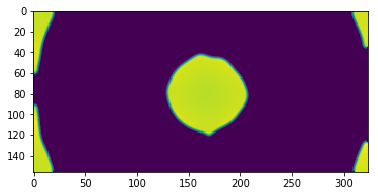

In [61]:
plt.pause(0.2)
temp = LS.phi.copy()
temp[temp<0]=0
plt.imshow(temp)
plt.pause(0.2)

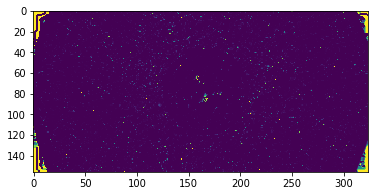

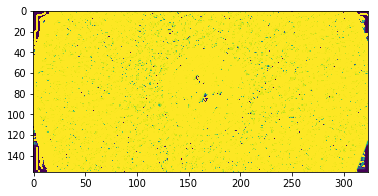

(array([1.23028090e-05, 1.23220997e-05, 1.23606339e-05, ...,
       6.66666667e-01, 8.00000000e-01, 1.00000000e+00]), array([  4,   1,   1, ...,  34, 135, 469]))


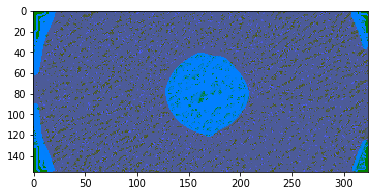

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 1

In [62]:
plt.imshow(LS.FI)
plt.pause(0.2)

color = np.array([255,0,0])
colored_img = np.ones((LS.phi.shape[0],LS.phi.shape[1],3), dtype=np.uint8)
colored_img[LS.phi<0] = color
# plt.imshow(colored_img)
# plt.pause(0.2)

yuv_img = cv2.cvtColor(colored_img, cv2.COLOR_BGR2YUV)
# plt.imshow( LS.FI[60:100] )
# plt.pause(0.2)
plt.imshow(( (1-LS.FI)**2 ))
plt.pause(0.2)
print(np.unique(LS.FI,return_counts=True))
y=2
yuv_img[:,:,y] = yuv_img[:,:,y] * ( (1-LS.FI)**2 )*100
plt.imshow(yuv_img)
plt.pause(0.2)
# print(np.unique(yuv_img, return_counts=True))

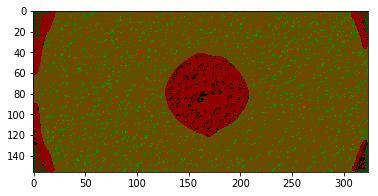

In [63]:
colored_img = cv2.cvtColor(yuv_img, cv2.COLOR_YUV2BGR)
# cv2.imshow('coloured',colored_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# colored_img[:,:,0] *= np.array(image/255,dtype=np.uint8)
# colored_img[:,:,1] *= np.array(image/100,dtype=np.uint8)
# colored_img[:,:,2] *= np.array(image/100,dtype=np.uint8)
plt.imshow(colored_img)
plt.pause(0.2)

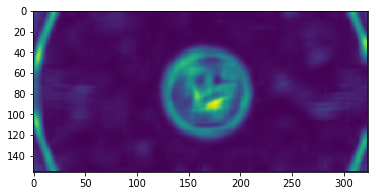

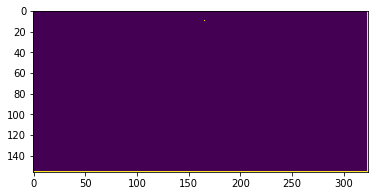

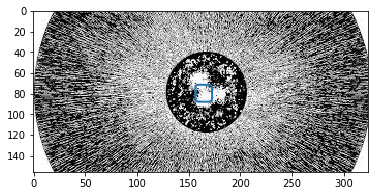

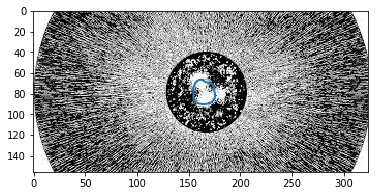

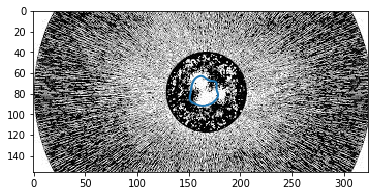

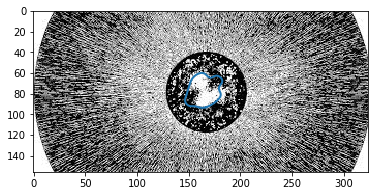

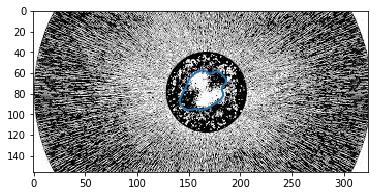

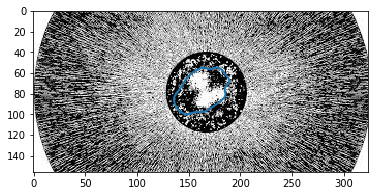

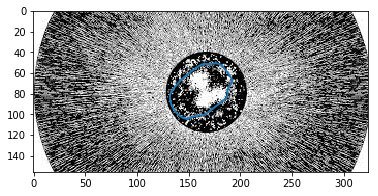

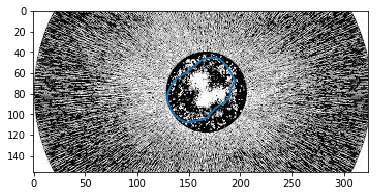

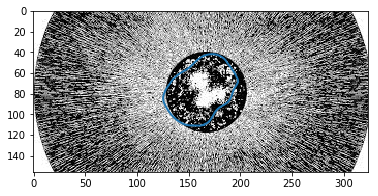

In [199]:
LS = levelSet(10,90,2,-100000000,2,0.8)#(10,3000,2,-9,2,0.8)
LS.gradientDescent(image,80,165)

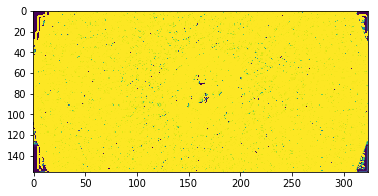

(array([1.23028090e-05, 1.23220997e-05, 1.23803363e-05, ...,
       6.66666667e-01, 8.00000000e-01, 1.00000000e+00]), array([  4,   1,   2, ...,  28, 158, 406]))


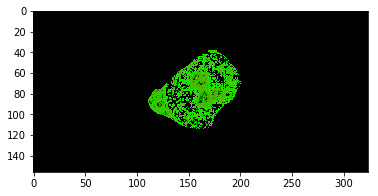

In [204]:
color = np.array([0,255,0])
# colored_img = np.ones((LS.phi.shape[0],LS.phi.shape[1],3), dtype=np.uint8)
colored_img[LS.phi<0] = color
# plt.imshow(colored_img)
# plt.pause(0.2)

yuv_img = cv2.cvtColor(colored_img, cv2.COLOR_BGR2YUV)
# plt.imshow( LS.FI[60:100] )
# plt.pause(0.2)
plt.imshow(( (1-LS.FI)**2 ))
plt.pause(0.2)
print(np.unique(LS.FI,return_counts=True))
y=0
yuv_img[:,:,y] = yuv_img[:,:,y] * ( (1-LS.FI)**2 )

colored_img = cv2.cvtColor(yuv_img, cv2.COLOR_YUV2BGR)
# cv2.imshow('coloured',colored_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
colored_img[:,:,0] *= np.array(image/10,dtype=np.uint8)
colored_img[:,:,1] *= np.array(image/10,dtype=np.uint8)
colored_img[:,:,2] *= np.array(image/10,dtype=np.uint8)
plt.imshow(colored_img)
plt.pause(0.2)